Authors :- AI21BTECH11003  and ES21BTECH11025

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as sc

Input intake

In [34]:
df = pd.read_csv('tvmarketing.csv')
print("dim of the data:",df.shape)


#Applying the suggestion of box -cox tranformation
df['Sales']  = df['Sales']**(0.585858585858586)
df['Sales'] -= np.mean(df['Sales'])
data = np.array(df)

dim of the data: (200, 2)


Likelihood function:-

In [35]:
def likelihood(data,theta):
    x = data[:,0]
    y = data[:,1]
    log_likelihood_vec = sc.norm.logpdf(y, loc=theta[0]*x+theta[1], scale=theta[2])
    log_likelihood = np.sum(log_likelihood_vec)
    return log_likelihood

Priors exploration :-

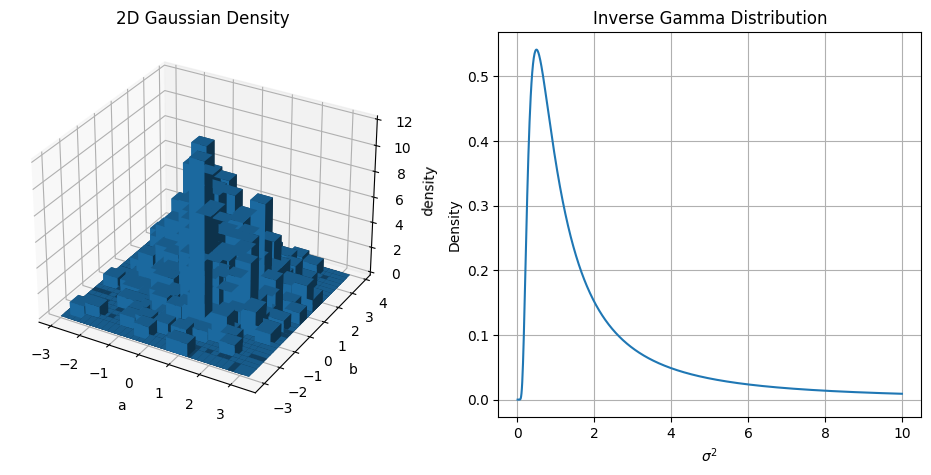

In [36]:

mean = [0, 0]
covariance = [[1, 0], [0, 1]]


samples = np.random.multivariate_normal(mean, covariance, size=1000)


fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121, projection='3d')

hist, xedges, yedges = np.histogram2d(samples[:, 0], samples[:, 1], bins=30)

xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('density')
ax.set_title('2D Gaussian Density')



x = np.linspace(0.01, 10, 1000)  
alpha = 1
beta = 1
pdf_values = sc.invgamma.pdf(x, alpha, scale=beta)
ax = fig.add_subplot(122)
ax.plot(x, pdf_values, label=f"Inverse Gamma({alpha},{beta})")
plt.title("Inverse Gamma Distribution")
plt.xlabel(r"$\sigma^2$")
plt.ylabel("Density")
plt.grid()
plt.show()


def prior(theta):
    mean = np.array([0,0])
    cov=np.eye(2)*100
    log_prior = sc.multivariate_normal.logpdf(theta[:2],mean=mean, cov=cov)
    alpha = 2
    beta = 2
    log_prior += sc.invgamma.logpdf(theta[2], a=alpha, scale=beta)
    return log_prior


Proposal distribtuion :-

In [37]:

def proposal(theta):
    theta_dash = np.zeros(3)
    theta_dash[:2] = sc.multivariate_normal(mean=theta[:2],cov=np.eye(2)*theta[2]).rvs(1)
    theta_dash[2] = sc.invgamma(a=2,scale =2).rvs(1)
    return theta_dash
def proposal_ratio(theta_old, theta_new):
    log_pro = sc.multivariate_normal.logpdf(theta_old[:2],mean=theta_new[:2], cov=np.eye(2)*theta_new[2])
    log_pro += sc.invgamma.logpdf(theta_old[2], a=2, scale=2)
    log_pro -= sc.multivariate_normal.logpdf(theta_new[:2],mean=theta_old[:2], cov=np.eye(2)*theta_old[2])
    log_pro -= sc.invgamma.logpdf(theta_new[2], a=2, scale=2)
    return log_pro

In [38]:
np.random.seed(100)
width = 0.2
a,b,c = np.random.rand(3)
thetas = [[a,b,c]]

N = 100000

for i in range(N):
    theta_dash = proposal(np.array(thetas[i]))
    log_lik_theta_dash = likelihood(data,theta_dash)
    log_lik_theta = likelihood(data,np.array(thetas[i]))
    theta_dash_prior = prior(theta_dash)
    theta_prior = prior(thetas[i])
    
    prop_ratio = proposal_ratio(np.array(thetas[i]), theta_dash)
    acceptance = np.clip(log_lik_theta_dash - log_lik_theta +theta_dash_prior - theta_prior + prop_ratio,-100,100)
    if np.exp(acceptance) > sc.uniform().rvs():
        thetas.append(theta_dash)
    else:
        thetas.append(thetas[i])

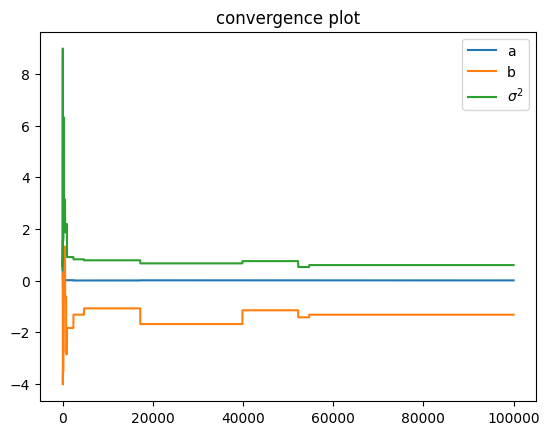

In [39]:

thet = np.array(thetas)
plt.plot(thet[:,0])
plt.plot(thet[:,1])
plt.plot(thet[:,2])
plt.legend(['a','b',r'$\sigma^2$'])
plt.title('convergence plot')
plt.show()

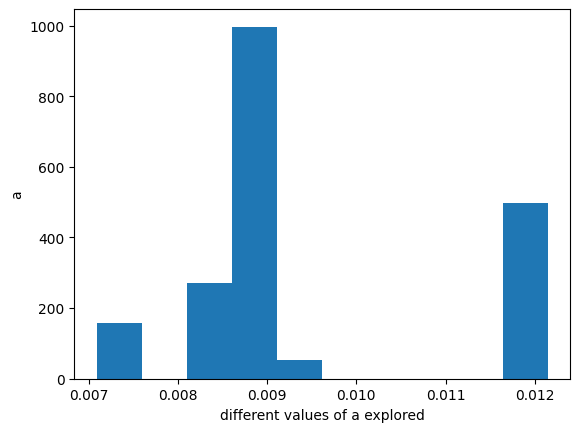

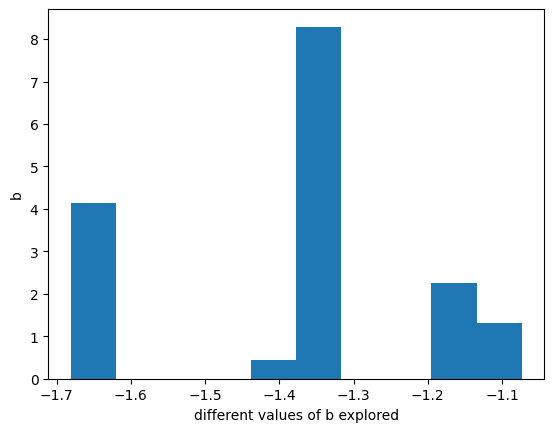

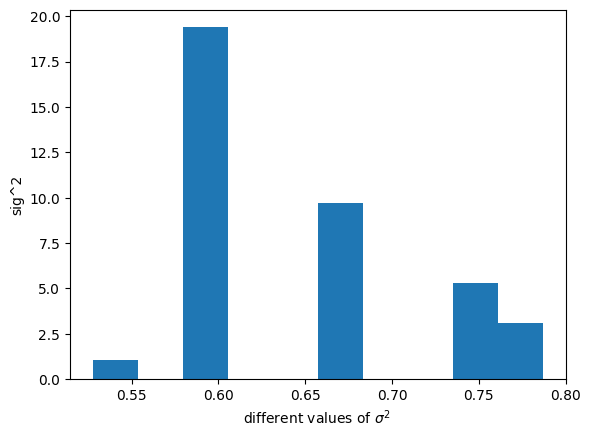

In [40]:
burn_in = 10000
thinning_period = 10
plt.hist(thet[:,0][burn_in:],density=True)
plt.ylabel('a')
plt.xlabel('different values of a explored')
plt.show()

plt.hist(thet[:,1][burn_in:],density=True)
plt.ylabel('b')
plt.xlabel('different values of b explored')
plt.show()


plt.hist(thet[:,2][burn_in:],density=True)
plt.ylabel('sig^2')
plt.xlabel(r'different values of $\sigma^2$ ')
plt.show()

In [41]:
print("mean for a:",np.mean(thet[:,0][burn_in:][::thinning_period]))
print("mean for b",np.mean(thet[:,1][burn_in:][::thinning_period]))
print("mean for sigma^2",np.mean(thet[:,2][burn_in:][::thinning_period]))

mean for a: 0.009509586379287305
mean for b -1.3697790612179213
mean for sigma^2 0.6529556602335899
